# Compare sea surface height model output and observations

Comparing the sea-surface height (ssh) from two different resolution runs. Specifically, we plot the time-mean and standard deviation of ssh and compare it to those obtained from observations from the CMEMS satellite altimetry dataset (former AVISO+ dataset).

In [1]:
from dask.distributed import Client

In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 48,Total memory: 188.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43523,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 188.56 GiB
Comm: tcp://127.0.0.1:46679,Total threads: 6
Dashboard: /proxy/42433/status,Memory: 23.57 GiB
Nanny: tcp://127.0.0.1:45149,


Here we pick a `start_time` and `end_time`. We select *only* 5 years of daily data for computational speed in this example. But you can probably extend the `end_time` until the end of 2018 (for model outputs) and up to middle of 2020 for observations.

In [3]:
# SSH variable in ACCESS-OM2 models
variable = 'sea_level'

start_time = '1993-01-01'
end_time = '1997-12-31'

## SSH from 1$^{\circ}$ and 0.25$^{\circ}$ model output

In [17]:
from esmvalcore.dataset import Dataset
model_datasets = {
"ACCESS-OM2": 
    Dataset(
    short_name='zos',
    project='CMIP6',
    activity='OMIP',
    mip="Omon",
    exp="omip2",
    ensemble="r1i1p1f1",
    timerange="0306/0366",
    dataset="ACCESS-OM2",
    grid="gn"
),
"ACCESS-OM2-025": 
    Dataset(
    short_name='zos',
    project='CMIP6',
    activity='OMIP',
    mip="Omon",
    exp="omip2",
    ensemble="r1i1p1f1",
    timerange="0306/0366",
    dataset="ACCESS-OM2-025",
    grid="gn"
)}

In [33]:
# model_datasets["ACCESS-OM2"].load()

## CMEMS satellite observational data (former AVISO+ dataset)

CMORised with ESMValTool

In [20]:
from esmvalcore.config import CFG
CFG['rootpath']['OBS6'].append(r'/g/data/kj13/datasets/esmvaltool/obsdata-v2')

obs = {"CMEMS": Dataset(dataset= 'CMEMS', project= 'OBS6', 
              type= '*', 
              timerange='1993/2023', 
              tier='2', 
              mip='Omon', short_name='zos')
      }


In [7]:
## preprocessers
from esmvalcore.preprocessor import climate_statistics

def mean_std(cube):
    m_cube = climate_statistics(cube, period="full", operator="mean")
    std_cube = climate_statistics(cube, period="full", operator="std_dev")
    return m_cube, std_cube

In [34]:
# obs_cube = obs.load()
data_res = {}
for name, ds in {**model_datasets,**obs}.items():
    data_res[name] = mean_std(ds.load())
# mean_std(obs_cube)
data_res

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(

{'ACCESS-OM2': (<iris 'Cube' of sea_surface_height_above_geoid / (m) (cell index along second dimension: 300; cell index along first dimension: 360)>,
  <iris 'Cube' of sea_surface_height_above_geoid / (m) (cell index along second dimension: 300; cell index along first dimension: 360)>),
 'ACCESS-OM2-025': (<iris 'Cube' of sea_surface_height_above_geoid / (m) (cell index along second dimension: 1080; cell index along first dimension: 1440)>,
  <iris 'Cube' of sea_surface_height_above_geoid / (m) (cell index along second dimension: 1080; cell index along first dimension: 1440)>),
 'CMEMS': (<iris 'Cube' of sea_surface_height_above_geoid / (m) (latitude: 1440; longitude: 2880)>,
  <iris 'Cube' of sea_surface_height_above_geoid / (m) (latitude: 1440; longitude: 2880)>)}

## Plot and compare

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


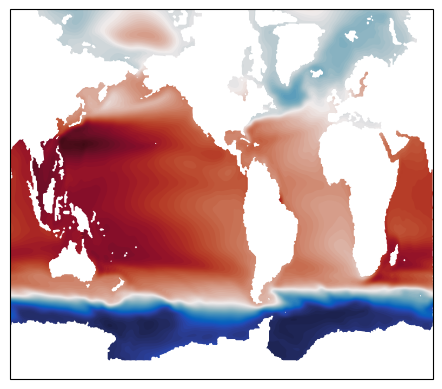

In [36]:
import iris.plot as iplt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean as cm

projection = ccrs.Robinson(central_longitude=-100)
plt.subplot(projection=projection)
mean, std = mean_std(model_datasets['ACCESS-OM2'].load())
iplt.contourf(mean, levels=100, cmap = cm.cm.balance)


Plot the time-mean and standard deviation of both of the model outputs and the CMEMS observational dataset (former AVISO+).

0 CMEMS RdBu_r
0 ACCESS-OM2 RdBu_r
0 ACCESS-OM2-025 RdBu_r
1 CMEMS YlGnBu
1 ACCESS-OM2 YlGnBu
1 ACCESS-OM2-025 YlGnBu
CPU times: user 1min 36s, sys: 20 s, total: 1min 56s
Wall time: 1min 56s


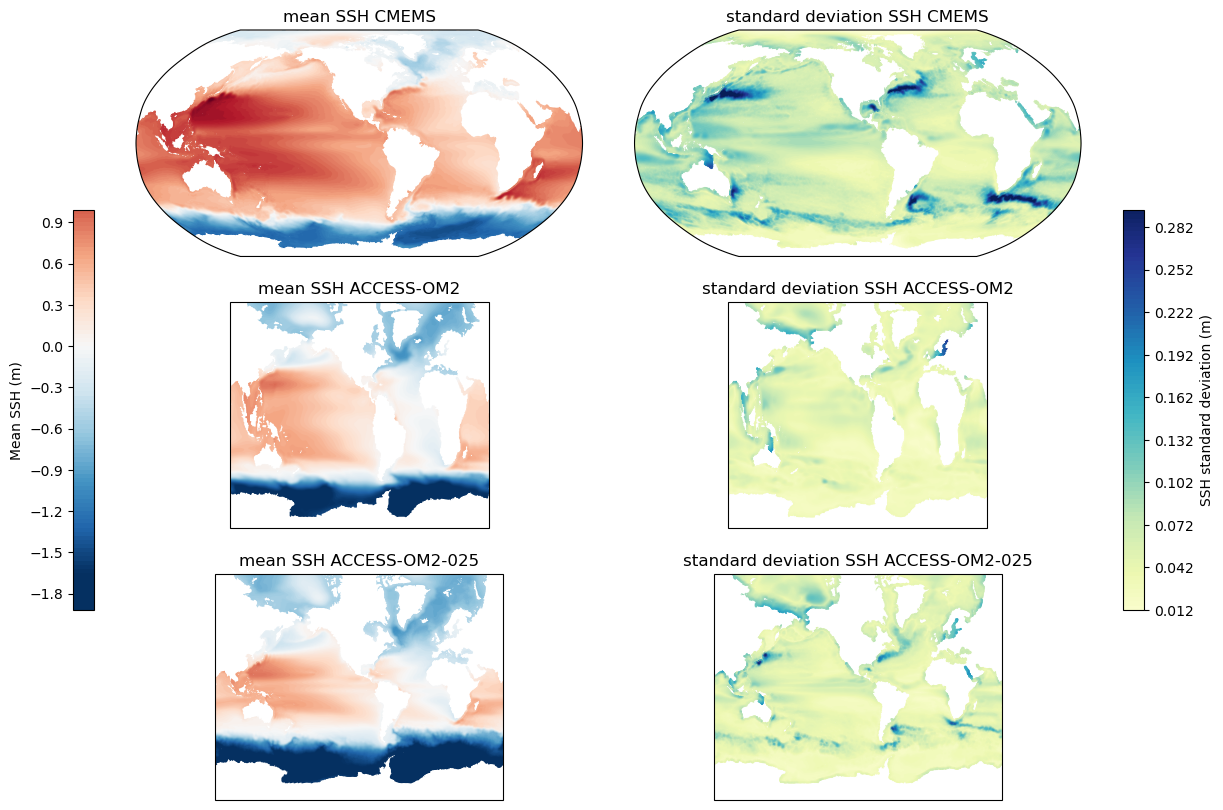

In [32]:
%%time

projection = ccrs.Robinson(central_longitude=-100)

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (14, 10),
                         subplot_kw={'projection': projection})
plt.subplots_adjust(wspace=-0.15)

max_std = 0.3
max_mean = 1.65
res = ['mean', 'standard deviation']
colmap = ['RdBu_r', 'YlGnBu']

for c, max_val in enumerate([max_mean, max_std]): #[0,1]: #mean, std

    for n, dataset in enumerate(data_res): #[0,1,2]: # data/models

        minv = -max_val if c == 0 else 0
        ax = axes[n,c]
        print(c, dataset, colmap[c])
        p1 = iplt.contourf(data_res[dataset][c],
                           axes=ax,
                           levels=100, 
                           vmin = minv,
                           vmax = max_val,
                           extend='both',
                           cmap=colmap[c])
        ax.set_title(f'{res[c]} SSH {dataset}')
        if c == 0:
            p0 = p1

# Colorbars
ax_cb1 = plt.axes([0.13, 0.3, 0.015, 0.4])
cb = plt.colorbar(p0, cax=ax_cb1, extend='both', label='Mean SSH (m)')
ax_cb1.yaxis.set_ticks_position('left')
ax_cb1.yaxis.set_label_position('left')

ax_cb2 = plt.axes([0.88, 0.3, 0.015, 0.4])
cb = plt.colorbar(p1, cax=ax_cb2, extend='max', label='SSH standard deviation (m)')

CPU times: user 58.3 s, sys: 4.28 s, total: 1min 2s
Wall time: 59.6 s


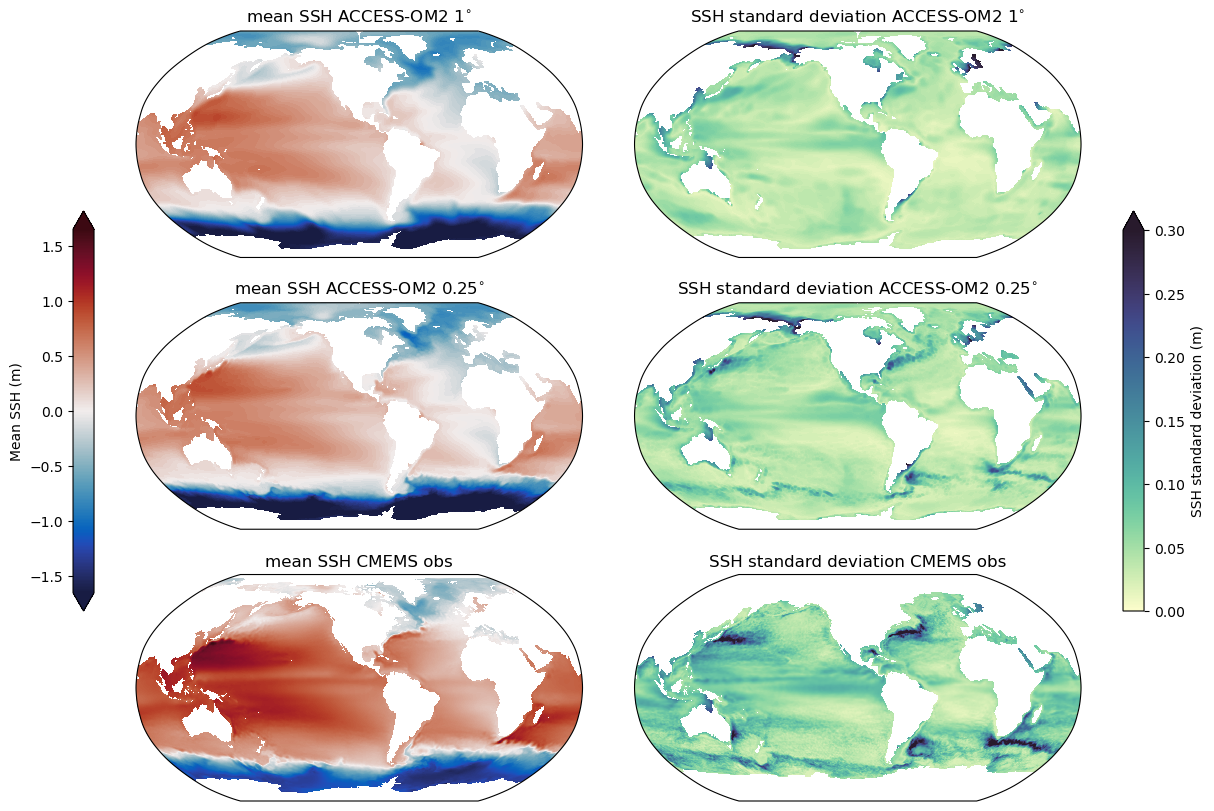

In [13]:
%%time

projection = ccrs.Robinson(central_longitude=-100)

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (14, 10),
                         subplot_kw={'projection': projection})
plt.subplots_adjust(wspace=-0.15)

max_std = 0.3
max_mean = 1.65

# mean SSH plots
ax = axes[0, 0]
p1 = ssh1_mean.plot.contourf(
    ax = ax,
    x = "geolon_t",
    y = "geolat_t",
    levels = 100,
    vmin = -max_mean,
    vmax = +max_mean,
    add_colorbar=False,
    cmap = cm.cm.balance,
    transform = ccrs.PlateCarree())
ax.set_title('mean SSH ACCESS-OM2 1$^{\circ}$')

ax = axes[1, 0]
p1 = ssh025_mean.plot.contourf(
    ax = ax,
    x = "geolon_t",
    y = "geolat_t",
    levels = 100,
    vmin = -max_mean,
    vmax = +max_mean,
    add_colorbar=False,
    cmap = cm.cm.balance,
    transform = ccrs.PlateCarree())
ax.set_title('mean SSH ACCESS-OM2 0.25$^{\circ}$')

ax = axes[2, 0]
p1 = obs_ssh_mean.plot(ax=ax, transform=ccrs.PlateCarree(),
                       cmap=cm.cm.balance, vmin=-max_mean, vmax=max_mean, add_colorbar=False)
ax.set_title('mean SSH CMEMS obs')

# std SSH plots
ax = axes[0, 1]
p2 = ssh1_std.plot.contourf(
    ax = ax,
    x = "geolon_t",
    y = "geolat_t",
    levels = 100,
    vmin = 0,
    vmax = max_std,
    add_colorbar=False,
    cmap = cm.cm.deep,
    transform = ccrs.PlateCarree())
ax.set_title('SSH standard deviation ACCESS-OM2 1$^{\circ}$')

ax = axes[1, 1]
p2 = ssh025_std.plot.contourf(
    ax = ax,
    x = "geolon_t",
    y = "geolat_t",
    levels = 100,
    vmin = 0,
    vmax = max_std,
    add_colorbar=False,
    cmap = cm.cm.deep,
    transform = ccrs.PlateCarree())
ax.set_title('SSH standard deviation ACCESS-OM2 0.25$^{\circ}$')

ax = axes[2, 1]
p2 = obs_ssh_std.plot(ax=ax, transform=ccrs.PlateCarree(),
                      cmap=cm.cm.deep, vmin=0, vmax=max_std, add_colorbar=False)
ax.set_title('SSH standard deviation CMEMS obs')

# Colorbars
ax_cb1 = plt.axes([0.13, 0.3, 0.015, 0.4])
cb = plt.colorbar(p1, cax=ax_cb1, extend='both', label='Mean SSH (m)')
ax_cb1.yaxis.set_ticks_position('left')
ax_cb1.yaxis.set_label_position('left')

ax_cb2 = plt.axes([0.88, 0.3, 0.015, 0.4])
cb = plt.colorbar(p2, cax=ax_cb2, extend='max', label='SSH standard deviation (m)');

In [14]:
client.close()